<h1><center>Flexible, probabilistic function modelling with Gaussian Processes:</center></h1>
<h1><center>Illustrating basics of Gaussian Process Regression</center></h1>
<h6><center>Athénaïs Gautier and
David Ginsbourger for Lifting Inference with Kernel Embeddings (LIKE22)
</center></h6>

# Loading packages and ensuring reproducibility

Within this notebook, we use the programming language *R*, with the packages *ggplot2* and *ggpubr* (for plots), *MASS* (to draw from multivariate normal distributions) and *kergp* (to fit Gaussian Process models). Additionally, we rely on the R-package *viridis* as it provides color palettes "designed to be perceived by readers with the most common form of color blindness and color vision deficiency".

However, we stress that the principles tackled here are general and not limited to one language, and carefuly-designed libraries GP-based method are available in most programing languages. 

In [3]:
# Loading kerp
library(kergp)
library(MASS)
#Reproducibility
set.seed(123)
version[['version.string']]
cat("kergp version", as.character(packageVersion("kergp")[1]))
# Setup ggplot
library(ggplot2)
theme_set(theme_bw())
options(repr.plot.width=8, repr.plot.height=4)
library(ggpubr)
library(viridis)
col_palette <- viridis_pal(option = "viridis", begin=0.05, end=0.95)(4)
col_palette2 <- viridis_pal(option = "inferno", begin=0.2, end=0.8)(4)

[1] "R version 3.6.1 (2019-07-05)"

kergp version 0.5.5

## Kriging: the underlying assumptions

In GP modeling, we work with the assumption that the function of interest $f$ is, a priori, a realization of a GP $(Z_x)_{x\in D}$. Therefore, performing GPR requires specifying:

* A mean value for the field $Z$, noted $m$. 
  * When the mean value is assumed to be known, GPR is also called **simple** kriging.
  * When the mean value is unknown but assumed to be constant, GPR is also called **ordinary** kriging.
  * When the mean value is unknown and not assumed to be constant, GPR is also called **universal** kriging.
* A covariance function, or (covariance) kernel for $Z$, noted $k$.
  * Often, $k$ depends on a number of hyper-parameters such as a variance parameter, or lengthscales. 
  
### Choosing a kernel

Specifying a kernel $k$ can be an involved task, and allows practitionners to inject structural knowledge in the model. For illustration, here is a short list of common **stationary** kernels on $\mathbb R$, and some of their properties. Most of these kernels will be parametrized by a variance hyper-parameter, denoted $\sigma^2$, and a lenghtscale, denoted $\theta$.

Regarding smoothness of the trajectories:

* <ins>Exponential (or Matérn 1/2) kernel</ins>, given by $k(x,y)=\sigma^2\exp\left(-\frac{\vert x-y\vert}{\theta}\right)$, yields almost-surely (a.s.) continuous non-differenciable GPs. 
* <ins>Matérn 3/2 kernel</ins>, given by $k(x,y)=\sigma^2\left(1+\frac{\sqrt{3}\vert x - y \vert}{\theta}\right)\exp\left(-\frac{\sqrt{3}\vert x - y \vert}{\theta}\right)$, yields a.s. once-differenciable GPs. 
* <ins>Matérn 5/2 kernel</ins>, given by $k(x,y)= \sigma^2\left(1+\frac{\sqrt{5}\vert x - y \vert}{\theta}+\frac{5\vert x - y \vert^2}{3\theta^2}\right)\exp\left(-\frac{\sqrt{5}\vert x - y \vert}{\theta}\right)$, yields  a.s. twice-differenciable GPs. 
* <ins>Squared exponential (or Gaussian) kernel</ins>, given by $k(x,y)=\sigma^2\exp\left(-\frac{\vert x-y\vert^2}{2 \theta^2}\right)$, yields  a.s. $\inf$-differenciable GPs. 

Some other properties:
* <ins>Linear kernel</ins>, given by $k(x,y)=\beta_0 + \sigma^2(x-c)(y-c)$, yields almost-surely (a.s.) affine GPs. It is parametrised by:
  * $c$, the offset, i.e. the x-coordinate of the point that all the lines in the posterior go through if $\beta_0=0$. 
  * $\beta_0$ which essentially specifies a prior on the value at $0$.
* <ins>Periodic (sin) kernel</ins>, given by $k(x,y)=\sigma^2\exp\left(-\frac{2}{\theta^2}\sin^2\left(\frac{\pi \vert x-y\vert}{p}\right)\right)$, yields a.s. p-periodic GPs. It is parametrised by:
  * $p > 0$, its period.
  
We can draw samples from zero-mean GPs endowed with some of these covariance structures to visually assess the difference between the different GPs.


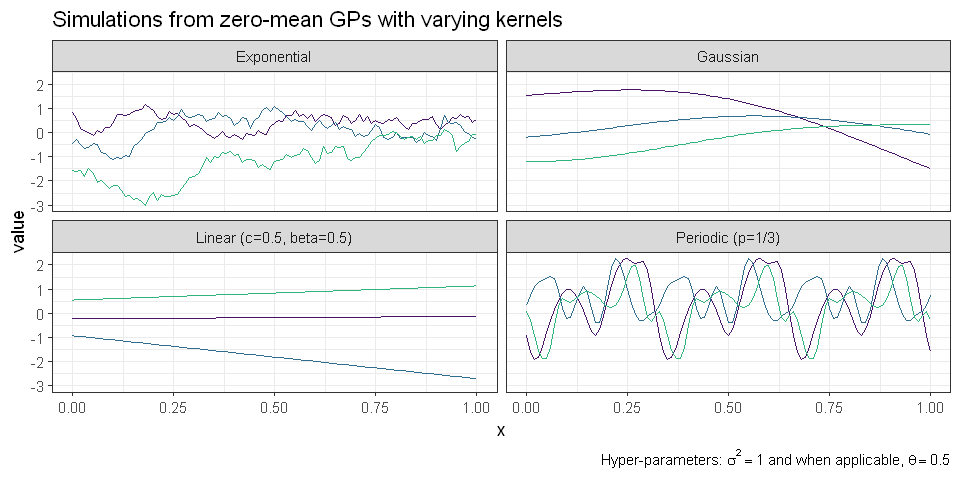

In [4]:
# Simulating GPs with the chosen kernels
nsim <- 3 #number of simulations
u <- data.frame(x=seq(0, 1, 0.01)) #We will simulate trajectories on (0, 1)

kExp <- k1Exp
coef(kExp) <- c(range=0.5, var=1)
yExp <- simulate(kExp, nsim = nsim, X = u) # Simulating from the 1D exponential kernel with the kergp package

kGauss <- k1Gauss
coef(kGauss) <- c(range=0.5, var=1)
yGauss <- simulate(kGauss, nsim = nsim, X = u) # Simulating from the 1D Gaussian kernel with the kergp package

kPeriodic <- covMan(kernel=function(x1, x2, par){
    h <- abs(x1 - x2) / par[1]
    k <- par[3]*exp(-2*(sin(pi*h))^2/par[2]^2)
    return(k)},
                    d = 1,
                    parLower = c(p=0, theta = 0.0, sigma2 = 0.0),
                    parUpper = c(p=Inf, theta = Inf, sigma2 = Inf),
                    parNames = c("p", "theta", "sigma2"),
                    par = c(p=0.33, theta = 0.5, sigma2 = 1))
inputNames(kPeriodic) <- c("x")
yPeriodic <- simulate(kPeriodic, nsim = nsim, X = u) # Simulating from the Periodic kernel with the kergp package

kLinear <- covMan(kernel=function(x1, x2, par){return(par[3]+par[2]*(x1-par[1])*(x2-par[1]))},
                    d = 1,
                    parLower = c(c=0,  sigma2 = 0.0, beta=-Inf),
                    parUpper = c(c=Inf,  sigma2 = Inf, beta=Inf),
                    parNames = c("c", "sigma2", "beta"),
                    par = c(c=0.5, sigma2 = 1, beta=0.5))
inputNames(kLinear) <- c("x")
yLinear <- simulate(kLinear, nsim = nsim, X = u) # Simulating from the Periodic kernel with the kergp package

# Storing them in a dataframe
df_prior_GP <- data.frame(x=rep(u$x, nsim*4), 
                          real=rep(sapply(seq(nsim), function(x){rep(x, nrow(u))}), 4),
                          kernel=c(sapply(c("Linear (c=0.5, beta=0.5)",
                                            "Exponential",
                                            "Gaussian",
                                            "Periodic (p=1/3)"), function(x){rep(x, nrow(u)*nsim)})),
                          value=c(yLinear, yExp, yGauss, yPeriodic))
# Plot
ggplot(df_prior_GP, aes(x=x, y=value, col=as.factor(real), group=real))+
  geom_line()+
  facet_wrap(kernel~., nrow=2)+
  theme(legend.position = "none")+
  ggtitle("Simulations from zero-mean GPs with varying kernels")+
  labs(caption=expression(paste("Hyper-parameters: ", sigma^2==1, " and when applicable, ", theta==0.5))) + 
  scale_color_manual(values=col_palette)

For an admissible kernels $k$, it is also possible to construct other kernels with certain properties. They can yield:
* GPs with a.s. a null-integral,
* GPs with physical invariances (symetries, differential equations, etc...).

We will not go into more details here, the topic will be adressed by David after this tutorial.

### Selecting hyper-parameters

As we saw, most kernels depend on so-called hyper-parameters. The choice of these parameters will also be important. Typically, most kernels have:

* A variance: it determines how much the GP can vary from its mean,
* Lengthscale: it determines the length of the 'wiggles' in the GP sample paths.

We display below simulations of zero-mean GPs with Gaussian kernel (i.e. infinitely smooth) but varying variance and lengthscale.

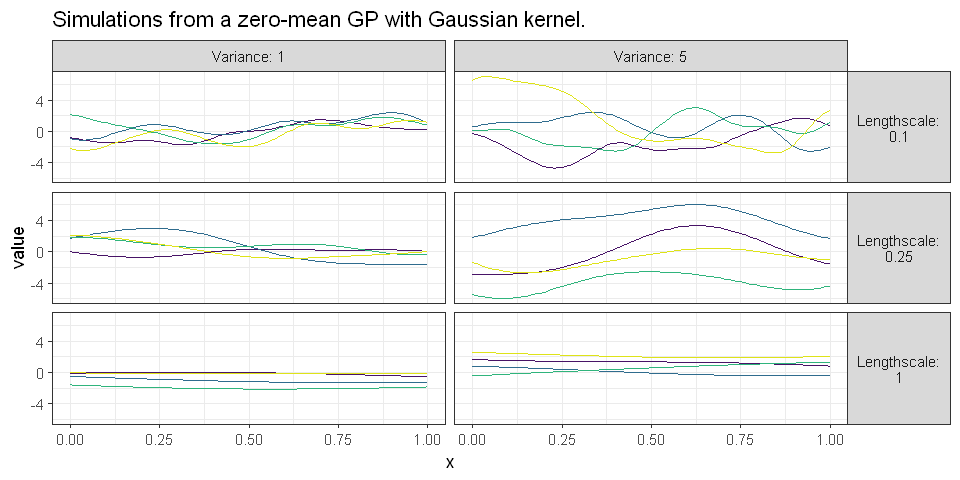

In [5]:
# Simulating GPs with a Gaussian kernel with varying hyper-parameters
nsim <- 4
u <- data.frame(x=seq(0, 1, 0.01))

df_prior_GP <- data.frame()
values_lengthscale <- c(0.1, 0.25, 1)
values_var <- c(1, 5)
kGauss <- k1Gauss
for(var in values_var){
    for(lengthscale in values_lengthscale){
        coef(kGauss) <- c(range=lengthscale, 
                          var=var)
        y <- simulate(kGauss, nsim = nsim, X = u) # Simulating from the 1D Gaussian kernel with the kergp package
        df_prior_GP<- rbind(df_prior_GP, 
                           data.frame(x=rep(u$x,nsim),
                                     var=var,
                                      real=c(sapply(seq(nsim), function(x){rep(x, nrow(u))})),
                                     lengthscale=lengthscale,
                                     value=c(y)))
    }
}


ggplot(df_prior_GP, aes(x=x, y=value, col=as.factor(real), group=real))+
  geom_line()+
  facet_grid(paste0("Lengthscale:\n", lengthscale)~paste0("Variance: ", var))+
  theme(legend.position = "none")+
  theme(strip.text.y = element_text(angle = 0))+
  ggtitle("Simulations from a zero-mean GP with Gaussian kernel.")+ 
  scale_color_manual(values=col_palette)

# How to perform Gaussian Process Regression

To perform spatial inference of $Z$ at an unobserved location $x_{n+1}$ we rely on the conditional expectation of $Z_{x_{n+1}}$ knowing $Z_{\mathbf X_n} = \mathbf z_n$ with $\mathbf z_n = (f(x_1), ..., f(x_n))'$.

## One-dimensional case

We will start by illustrating (GPR) on a 1-dimensional function. The considered function was introduced in Xiong et al. 2007 and writes as follows:
$$ f(x)= \sin\left(30 (x - 0.9)^4\right) \cos \left(2 (x - 0.9) \right) + (x - 0.9) / 2 , \ x\in (0, 1)$$

We measure the function without noise at $n$ candidates points $X_n = (x_1, ..., x_n)$. Here, we consider $n=5$ locations, namely: 0.1, 0.2, 0.5, 0.6, 0.8.


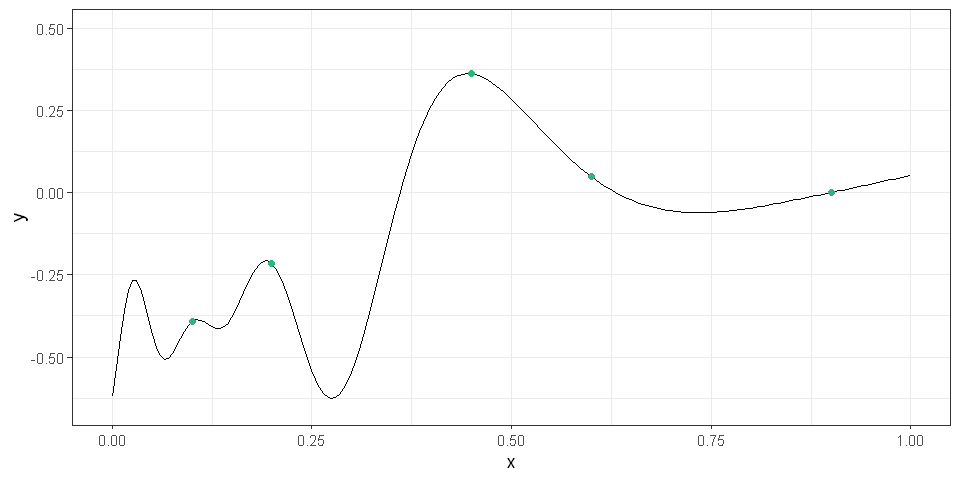

In [6]:
f <- function(x){
  sin(30 * (x - 0.9)^4) * cos(2 * (x - 0.9)) + (x - 0.9) / 2
}

df_ref <- data.frame(x=seq(from = 0, to = 1., by = 0.005))
df_ref$y <- f(df_ref$x)

#Where do we have observations
X <- c(0.1, 0.2, 0.45, 0.6, 0.9) #Observed locations
N <- length(X)
df_obs <- data.frame(x=X, y=f(X))

#Plot
plot_ref <- ggplot(mapping=aes(x=x, y=y)) + 
  geom_line(data=df_ref)+
    geom_point(data=df_obs, mapping=aes(x=x, y=y), col=col_palette[3])+
    coord_cartesian(ylim=c(-.65, 0.5), xlim=c(0, 1.))
plot_ref

## Simple kriging 

We start by performing **simple kriging**. With simple kriging, we assume that the mean value is perfectly known and denoted $m(x)$.

Under this model, $Z_{x_{n+1}} \vert Z_{\mathbf X_n} = \mathbf z_n$ follows a normal distribution $\mathcal{N}(m_n(x_{n+1}), s_n^2(x_{n+1}))$ with:
* The simple kriging mean $m_n(x_{n+1})= m(x_{n+1}) + k(x_{n+1}, \mathbf X_n) k(\mathbf X_n, \mathbf X_n)^{-1} (\mathbf z_n - m(x_{n+1}))$
* The simple kriging variance $s_n^2(x_{n+1})= k(x_{n+1}, x_{n+1}) - k(x_{n+1}, \mathbf X_n) k(\mathbf X_n, \mathbf X_n)^{-1} k(\mathbf X_n, x_{n+1})$

Let us start by performing simple kriging at one location: $x_{n+1}=0.35$. 

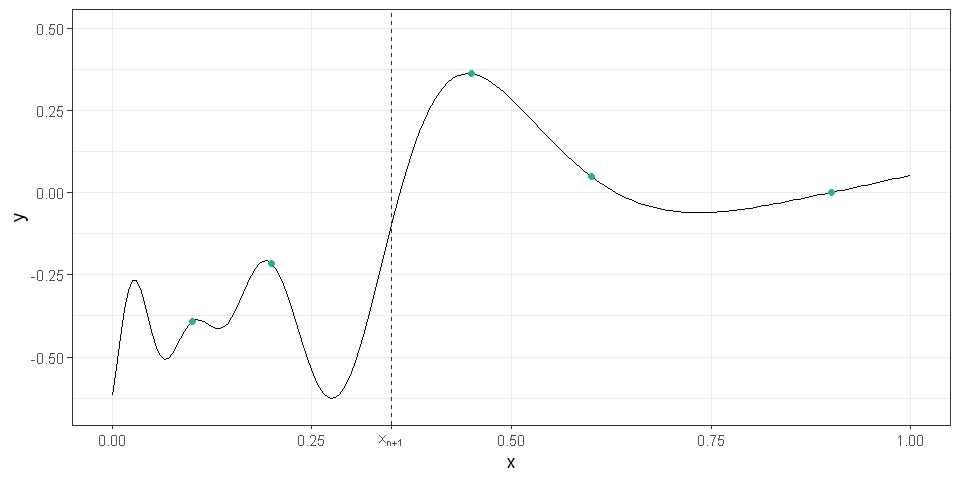

In [7]:
# Where do we want to predict
xnew <- 0.35
plot_mid <- plot_ref + 
  geom_vline(xintercept=xnew, lty=2, col=col_palette[1] )+ #Prediction location
  scale_x_continuous(labels=c("0.00", "0.25", "0.50", "0.75", "1.00", expression(x[n+1])), breaks=c(seq(0, 1, 0.25), xnew),
                    minor_breaks = c())
plot_mid

We arbitrarily set a first model:
 * A constant mean $m(x)=0$
 * A Gaussian kernel with variance $2$, and lengthscale $0.3$
 
We start by pre-computing the matrices and vector that appear at least twice in the kriging mean and variance:
 * $k(\mathbf X_n, x_{n+1})=k(x_{n+1}, \mathbf X_n)'$,
 * $k(\mathbf X_n, \mathbf X_n)$ and its inverse,
 * and the so-called kriging weights given by $k(x_{n+1}, \mathbf X_n) k(\mathbf X_n, \mathbf X_n)^{-1}$.

In [8]:
# Covariance kernel (Matérn 5/2)
k <- k1Gauss

# Initial hyper-parameters
coef(k) <- c(range=0.3, var=2)

# Covariance matrix K(X_n, X_n) and its inverse 
K <- covMat(k, df_obs)
Kinv <- solve(K)

# Covariance k(X_n, x_new)
knew <- covMat(k, df_obs, data.frame(x=xnew))

# Kriging weights
kweights <- t(knew) %*% Kinv 

In [9]:
# Kriging mean and variance
kriging_mean <- (kweights%*%(df_obs$y))[1]
print(paste0("Simple kriging mean: ", kriging_mean))
kriging_var <- (covMat(k, data.frame(x=xnew)) - kweights%*%knew)[1]
print(paste0("Simple kriging standard deviation: ", sqrt(kriging_var)))

[1] "Simple kriging mean: 0.25184092818341"
[1] "Simple kriging standard deviation: 0.0246673219089135"


Since we are interested in the conditional distribution of $Z_{x_{n+1}}$ knowing $Z_{\mathbf X_n} = \mathbf z_n$, let us represent it on a plot

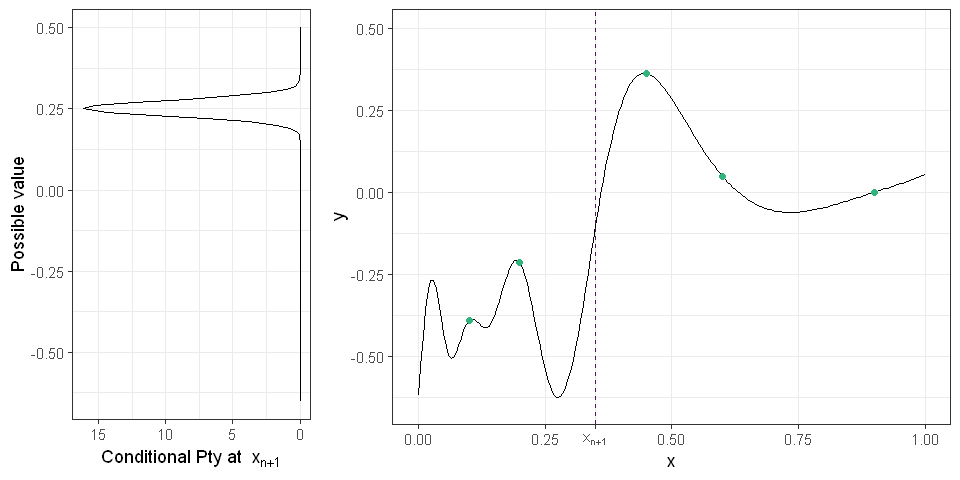

In [10]:
u1 <- seq(-0.65, 0.5, 0.01)
plot_left <- ggplot(data.frame(x=u1,
                                y=dnorm(u1, mean=kriging_mean, sd=sqrt(kriging_var))), 
                     aes(x=x, y=y))+ # Conditional dist. at x0
  geom_line()+
  xlab(expression("Possible value"))+
  ylab(expression("Conditional Pty at "~x[n+1]))+
  coord_flip()+
  scale_y_reverse()
ggarrange(plot_left, plot_mid, nrow=1, ncol=2, widths = c(1, 2))

### A detour through the estimator point of view:

The **simple kriging mean** (under null-mean assumption) $m_n(x_{n+1})= k(x_{n+1}, \mathbf X_n) k(\mathbf X_n, \mathbf X_n)^{-1} \mathbf z_n$ is linear in the GP observed values. 

If we use its random counter-part (by leaving $\mathbf z_n$ in random form), and under the model assumptions, we obtain a **Linear Estimator** of $Z_{x_{n+1}}$, that we will denote $\hat{Z}_{x_{n+1}}$. The variance of this estimator is exactly $s_n^2(x_{n+1})$.

One can prove that the kriging weights $(w_1, ..., w_n) = k(x_{n+1}, \mathbf X_n) k(\mathbf X_n, \mathbf X_n)^{-1} $ can be found by minimizing the expected quadratic error: $\mathbb{E}\left[ \left( Z_{x_{n+1}} - \sum w_i Z_{x_i} \right)^2 \right]$. 

This remark will be useful later in the presentation, when considering other kriging models with more complex structures. 

For the time being, let us continue studying simple kriging, by displaying the point estimate for our exemple:

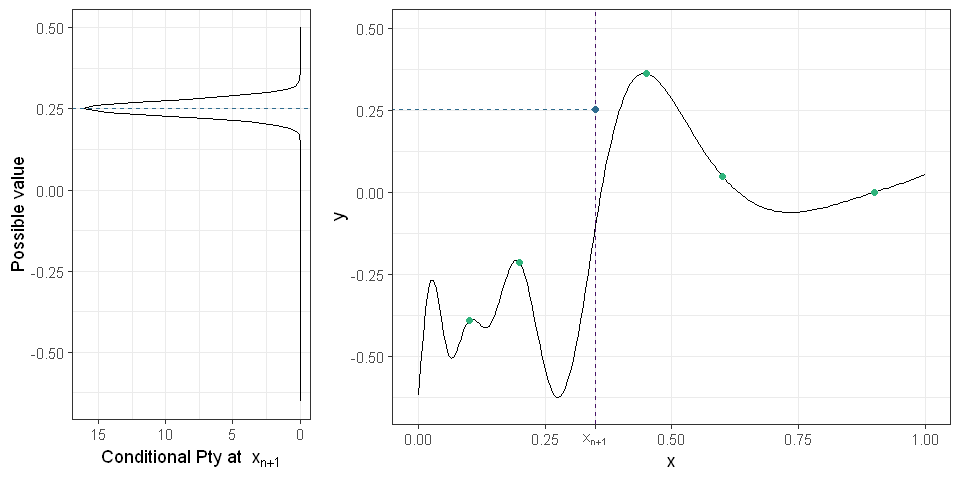

In [11]:
plot_left <- plot_left+
  geom_vline(xintercept=kriging_mean,  col=col_palette[2], lty=2)
plot_mid <- plot_mid +
  geom_point(data=data.frame(x=xnew, y=kriging_mean), col=col_palette[2])+
  geom_segment(aes(x=xnew,xend=xnew-3,y=kriging_mean,yend=kriging_mean), 
               lty=2, col=col_palette[2])
ggarrange(plot_left, plot_mid, nrow=1, ncol=2, widths = c(1, 2))

Having access to the conditional distribution of $Z_{x_{n+1}}$ knowing $Z_{\mathbf X_n} = \mathbf z_n$ also enables us to derive Confidence Interval estimates.
Indeed, for a confidence level $0<\alpha<1$, let us consider $\text{CI}_{\alpha}(x_{n+1}) := \left(m_n(x_{n+1}) \pm \Phi\left(\frac{\alpha}{2}\right) s_n(x_{n+1}) \right)$, where $\Phi$ denotes the cdf of the standard normal distribution. 
Then, it holds that:

$$P\left[ Z_{x_{n+1}} \in \text{CI}_{\alpha}(x_{n+1}) \vert Z_{\mathbf X_n}= \mathbf z_n \right] = 1-\alpha$$

We can represent this point-wise confidence interval in our plot. Here, we use $\alpha=0.05$.

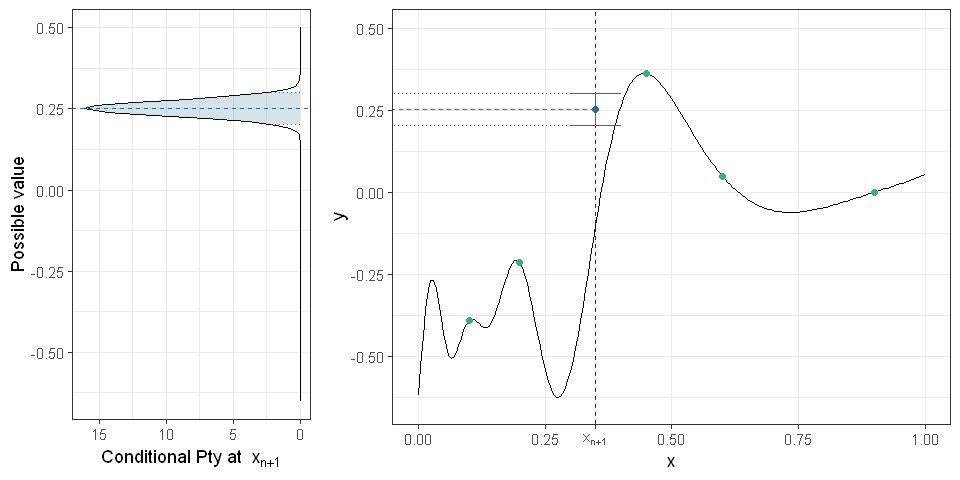

In [12]:
kriging_lower95 <- kriging_mean+ qnorm(0.025)*sqrt(kriging_var)
kriging_upper95 <- kriging_mean- qnorm(0.025)*sqrt(kriging_var)

u2 <- seq(kriging_lower95, kriging_upper95, length.out=50)
plot_left <- plot_left +
  geom_area(data=data.frame(x=u2,
                            y=dnorm(u2, 
                                    mean=kriging_mean, sd=sqrt(kriging_var))),
            fill=col_palette[2], alpha=0.2)+
  geom_segment(aes(x=kriging_upper95,xend=kriging_upper95,
                   y=0, yend=dnorm(kriging_upper95, mean=kriging_mean, sd=sqrt(kriging_var))),  
               col=col_palette[2], lty=3)+
  geom_segment(aes(x=kriging_lower95,xend=kriging_lower95,
                   y=0, yend=dnorm(kriging_lower95, mean=kriging_mean, sd=sqrt(kriging_var))),  
               col=col_palette[2], lty=3)
plot_mid<-plot_mid +
  geom_errorbar(data=data.frame(x=xnew, y=kriging_mean),
                ymin=kriging_upper95, 
                ymax=kriging_lower95,width=.1,
                position=position_dodge(.9), 
                col=col_palette[2])+
  geom_segment(aes(x=xnew,xend=xnew-3,y=kriging_lower95,yend=kriging_lower95), 
               lty=3, col=col_palette[2])+
  geom_segment(aes(x=xnew,xend=xnew-3,y=kriging_upper95,yend=kriging_upper95), 
               lty=3, col=col_palette[2])
ggarrange(plot_left, plot_mid,
          nrow=1, ncol=2, widths = c(1, 2))


### Considering two locations

Of course, the same approach can be used to perform inference at several locations. 

Let us consider that we now want to perform spatial inference at $x_{n+1 }$ and $x_{n+2}$ simultaneously. We also have a normal conditional expectation:


$$\left.\begin{pmatrix} Z_{x_{n+1 }}\\ Z_{x_{n+2 }}\end{pmatrix} \right\vert Z_{\mathbf X_n} = \mathbf z_n \sim \mathcal N \left( \begin{pmatrix} m_n(x_{n+1 })\\ m_n(x_{n+2 })\end{pmatrix}, \begin{pmatrix} s_n^2(x_{n+1}) & c_n(x_{n+1}, x_{n+2}) \\ c_n(x_{n+1}, x_{n+2}) & s_n^2(x_{n+2}) \end{pmatrix} \right) $$
where $s_n(x_{n+1}, x_{n+2}):=  k(x_{n+1}, x_{n+2}) - k(x_{n+1}, \mathbf X_n) k(\mathbf X_n, \mathbf X_n)^{-1} k(\mathbf X_n, x_{n+2}) $.


We note that:

* The mean and variance terms are the same as when we just consider $Z_{x_{n+1}} \vert Z_{\mathbf X_n} = \mathbf z_n$ and $Z_{x_{n+2}} \vert Z_{\mathbf X_n} = \mathbf z_n$ separately. And it is correct to say that we still have point-wise (or one-at-a-time) confidence intervals $\text{CI}_{\alpha}(x_{n+i}) = \left(m_n(x_{n+i}) \pm \Phi\left(\frac{\alpha}{2}\right) s_n(x_{n+i}) \right)$, such that $P\left[ Z_{x_{n+i}} \in \text{CI}_{\alpha}(x_{n+i}) \vert Z_{\mathbf X_n}= \mathbf z_n \right] = 1-\alpha$ ($i=1$ or $2$).


* However, in most cases we have $c_n(x_{n+1}, x_{n+2})\neq 0$ and therefore $P\left[ Z_{x_{n+1}} \in \text{CI}_{\alpha}(x_{n+1}) \text{ and } Z_{x_{n+2}} \in \text{CI}_{\alpha}(x_{n+2}) \vert Z_{\mathbf X_n}= \mathbf z_n \right] < 1-\alpha$.

With this in mind, we add a new location $x_{n+2}=0.65$ to our test-case.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


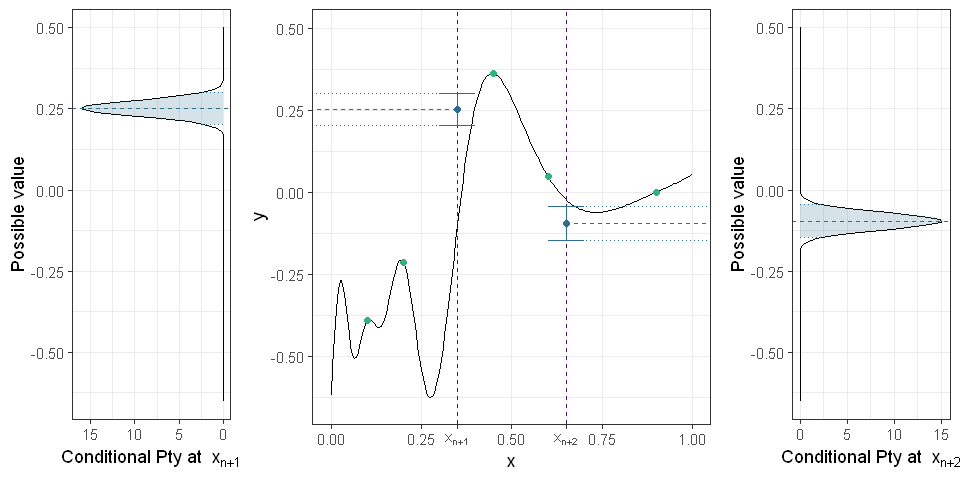

In [13]:
xnew_bis <- 0.65
# Covariance k(X_n, x_new)
knew_bis <- covMat(k, df_obs, data.frame(x=xnew_bis))

# Kriging weights
kweights_bis <- t(knew_bis) %*% Kinv 

# Kriging mean and variance
kriging_mean_bis <- (kweights_bis%*%(df_obs$y))[1]
kriging_var_bis <- (covMat(k, data.frame(x=xnew_bis)) - kweights_bis%*%knew_bis)[1]
kriging_lower95_bis <- kriging_mean_bis+ qnorm(0.025)*sqrt(kriging_var_bis)
kriging_upper95_bis <- kriging_mean_bis- qnorm(0.025)*sqrt(kriging_var_bis)

u3 <- seq(kriging_lower95_bis, kriging_upper95_bis, length.out=50)
plot_right <- ggplot(data.frame(x=u1,
                               y=dnorm(u1, mean=kriging_mean_bis, sd=sqrt(kriging_var_bis))), 
                    aes(x=x, y=y))+ # Conditional dist. at xnew_bis
  geom_line()+
  xlab(expression("Possible value"))+
  ylab(expression("Conditional Pty at "~x[n+2]))+
  coord_flip()+
  geom_vline(xintercept=kriging_mean_bis,  col=col_palette[2], lty=2)+
  geom_area(data=data.frame(x=u3,
                            y=dnorm(u3, 
                                    mean=kriging_mean_bis, sd=sqrt(kriging_var_bis))),
            fill=col_palette[2], alpha=0.2)+
  geom_segment(aes(x=kriging_upper95_bis,xend=kriging_upper95_bis,
                   y=0, yend=dnorm(kriging_upper95_bis, mean=kriging_mean_bis, sd=sqrt(kriging_var_bis))),  
               col=col_palette[2], lty=3)+
  geom_segment(aes(x=kriging_lower95_bis,xend=kriging_lower95_bis,
                   y=0, yend=dnorm(kriging_lower95_bis, mean=kriging_mean_bis, sd=sqrt(kriging_var_bis))),  
               col=col_palette[2], lty=3)
plot_mid<- plot_mid +
  geom_vline(xintercept=xnew_bis, lty=2, col=col_palette[1] )+ # New prediction location
  geom_point(data=data.frame(x=xnew_bis, y=kriging_mean_bis), col=col_palette[2])+
  geom_segment(aes(x=xnew_bis,xend=xnew_bis+3,y=kriging_mean_bis,yend=kriging_mean_bis), 
               lty=2, col=col_palette[2])+
  geom_errorbar(data=data.frame(x=xnew_bis, y=kriging_mean_bis),
                ymin=kriging_upper95_bis, 
                ymax=kriging_lower95_bis,width=.1,
                position=position_dodge(.9), 
                col=col_palette[2])+
  geom_segment(aes(x=xnew_bis,xend=xnew_bis+3,y=kriging_lower95_bis,yend=kriging_lower95_bis), 
               lty=3, col=col_palette[2])+
  geom_segment(aes(x=xnew_bis,xend=xnew_bis+3,y=kriging_upper95_bis,yend=kriging_upper95_bis), 
               lty=3, col=col_palette[2])+ #Prediction location
  scale_x_continuous(labels=c("0.00", "0.25", "0.50", "0.75", "1.00", expression(x[n+1]), expression(x[n+2])), 
                   breaks=c(seq(0, 1, 0.25), xnew, xnew_bis), minor_breaks = c())


ggarrange(plot_left, plot_mid, 
          plot_right, nrow=1, ncol=3, widths = c(1, 2, 1))


### Considering even more locations

The approach also scales to inference at $q$ locations, with the same idea being applied:

* The conditional distribution will be $q$-variate normal
* The conditional mean at $x_{n+i}$ will have $m_n(x_{n+i})$ as its $i$-th component.
* The conditional variance at $x_{n+i}$will be $s_n^2(x_{n+i})$
* The conditional covariance between $x_{n+i}$and $x_{n+j}$ will be $c_n(x_{n+i}, x_{n+j})= k(x_{n+i}, x_{n+j}) - k(x_{n+i}, \mathbf X_n) k(\mathbf X_n, \mathbf X_n)^{-1} k(\mathbf X_n, x_{n+j}) $

It is common to plot the 95% confidence interval, but as for the case $q=2$, one must keep in mind that they are point-wise interval.

Warning message in sqrt(gp_var):
"production de NaN"Warning message in sqrt(gp_var):
"production de NaN"

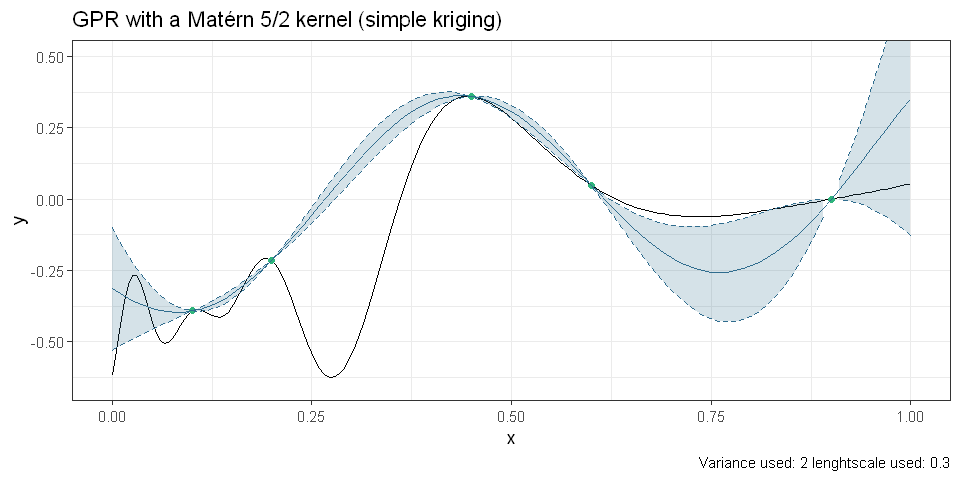

In [14]:
xnew <- seq(0, 1, length.out=101)

knew <- covMat(k, df_obs, data.frame(x=xnew))

# Kriging weights
kweights <- Kinv%*%knew 
kriging_mean <- t(kweights)%*%(df_obs$y)
kriging_varMat <- covMat(k, data.frame(x=xnew)) - t( knew) %*% kweights
kriging_var <- diag(kriging_varMat)

gp_plot <- function(initial_plot, gp_point, gp_mean, gp_var, df_sim=NULL){
  kriging_lower95 <- gp_mean+qnorm(0.025)*sqrt(gp_var)
  kriging_upper95 <- gp_mean+qnorm(0.975)*sqrt(gp_var)
  final_plot <- initial_plot + 
    geom_line(data=data.frame(x=gp_point,
                              y=gp_mean), 
              col=col_palette[2])+
    geom_ribbon(data=data.frame(x=gp_point,
                                ymin=kriging_lower95,
                                ymax=kriging_upper95), 
                inherit.aes=FALSE,
                mapping=aes(x=x, ymin=ymin, ymax=ymax),
                col=col_palette[2],
                fill=col_palette[2], lty=2, alpha=0.2)
    if(!is.null(df_sim)){
        final_plot <- final_plot+
  geom_line(df_sim, mapping=aes(x=x, y=y, col=as.factor(real), group=real), lwd=1.1)+
  geom_point(df_obs, mapping=aes(x=x, y=y), col=col_palette[3])+
  theme(legend.position="none")+
  scale_color_manual(values=col_palette2)
    }
  return(final_plot)
}

plot_SK_1 <- gp_plot(initial_plot=plot_ref, gp_point=xnew,
                     gp_mean=kriging_mean, gp_var=kriging_var ) + 
  ggtitle("GPR with a Matérn 5/2 kernel (simple kriging)")+
  labs(caption=paste0("Variance used: ", 2, " lenghtscale used: ", 0.3))
plot_SK_1

### Uncertainty quantification

We mentionned that the plotted confidence bounds were point-wise rather than simultaneous. Although they are instrumental for uncertainty quantification, they might not be enough. However, for such tasks, one can rely on conditional simulations.

Conditional simulations are drawn from the multivariate distribution of $(Z_{x_{n+1}}, ..., Z_{x_{n+q}})' \vert Z_{\mathbf X_n}=\mathbf z_n$.

Here, we perform such simulations:

Warning message in sqrt(gp_var):
"production de NaN"Warning message in sqrt(gp_var):
"production de NaN"

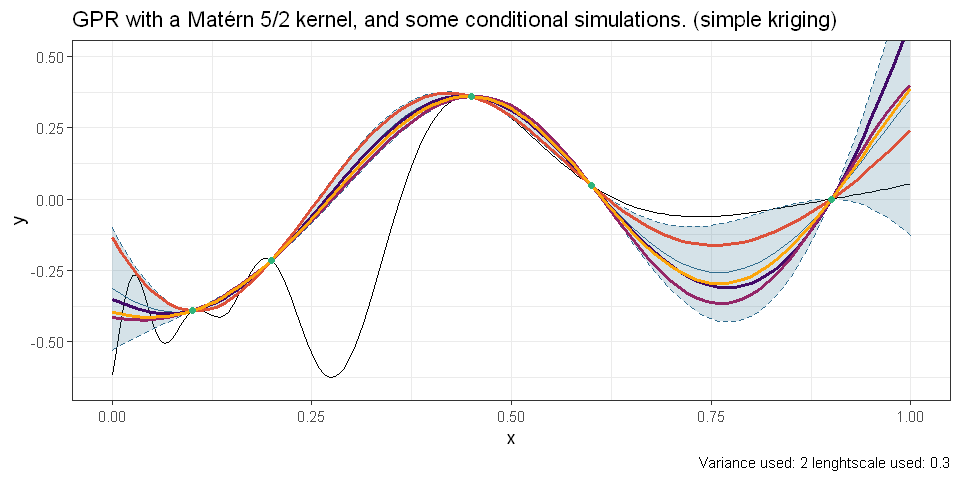

In [15]:
simu <- mvrnorm(nsim, mu=kriging_mean, Sigma=kriging_varMat)
df_simu <- data.frame(x=rep(xnew, nsim), y=c(t(simu)), real=c(t(matrix(seq(nsim), nrow=nsim, ncol=length(xnew)))))
plot_SK_1 <- gp_plot(initial_plot=plot_ref, gp_point=xnew,
                     gp_mean=kriging_mean, gp_var=kriging_var, df_sim=df_simu ) + 
  labs(caption=paste0("Variance used: ", 2, " lenghtscale used: ", 0.3))+
  ggtitle("GPR with a Matérn 5/2 kernel, and some conditional simulations. (simple kriging)")
plot_SK_1

# How to improve ?

One notices that the model is over-confident in its estimation on the left-side of the domain. Of course, a better fit could be achieved by adding observations, however, it is not the only way to improve upon the current model.


## Numerical stability

In the previous exemple, despite the apparent simplicity of the application, there are some stability issues. Some values of the kriging standard deviation could not be obtained, as the kriging variance contains values that should be zero but are actually extremely small negative values.

In [16]:
kriging_var[kriging_var<0]

[1] -4.440892e-16

The numerical stability can be improved by carefully considering the algebraic operations at hand. This is done in the vast majority of packages and libraries, and we will therefore stop implementing the GPR manually and rely on one of them, namely the *kergp* package.


## Model specification

There are several other ways to improve upon the current model. One can consider:

### Changing the kernel $k$. 

As we saw, selecting a kernel implies injecting structural knowledge on $f$. Carefully selecting a suitable kernel is crucial, and requires practitioners to consider, among other things: which level of smoothness they want their GP to achieve, whether they want to incorporate other properties (invariances, periodicity, etc.), whether the covariance should be stationary, isotropic, etc...

### Changing the trend assumptions. 

Until now, we worked under the assumption that the trend was known and equal to zero. However, in practice we rarely have access to such information.

In **ordinary kriging**, one assumes that the mean $m(x)$ is equal to an unknown constant $\mu$.

#### Reminder on Simple Kriging:

We saw previously that for the 0-mean simple kriging, one could either consider:

* The conditional distribution of $Z_x$ knowing $Z_{\mathbf X_n}=\mathbf z_n$ (under the assumption that $Z$ was a zero-mean GP), characterized by the kriging mean and kriging variance.
* The linear estimator $\hat Z_x = \sum_i w_i(x) Z_{x_i} $, found by minimizing the expected quadratic error at $x$: 
$\mathbb{E}\left[ \left( Z_{x} - \sum_i w_i(x) Z_{x_i} \right)^2 \right]$. Basic computations show that this estimator corresponds to the random form of the kriging mean, and its variance at $x$ is exactly the simple kriging variance.

#### Counterpart for Ordinary Kriging: estimator point of view

When performing OK, one must account for the unknown mean $\mu$. It is quite straightforward to extend the estimator-based approach in this setting and to focus on finding an **unbiased linear estimator** of $Z$ at $x_{n+1}$.
This boils down to solving the constrained problem:

$$\text{minimize } \mathbb{E}\left[ \left( Z_{x_{n+1}} - \sum_i w_i(x_{n+1}) Z_{x_i} \right)^2 \right] $$
$$\text{under the constraint } \mathbb{E}\left[ \sum_i w_i(x_{n+1}) Z_{x_i} \right] = \mathbb{E}\left[Z_{x_{n+1}} \right]$$

Solving this optimisation problem results in the ordinary kriging system:

$$\begin{pmatrix}w_1 \\ \vdots \\ w_n \\ \mu \end{pmatrix}= \begin{pmatrix} k(x_{1}, x_{1}) & \cdots & k(x_{1}, x_{n}) & 1\\ \vdots & \ddots & \vdots & \vdots \\ k(x_{n}, x_{1}) & \cdots & k(x_{n}, x_{n}) & 1 \\ 1 & \cdots & 1 & 0 \end{pmatrix}^{-1} \begin{pmatrix} k(x_{1}, x_{n+1}) \\ \vdots \\ k(x_{n}, x_{n+1}) \\ 1 \end{pmatrix}$$

and in turn we get:

* The estimator of the mean: $\hat{\mu} = \dfrac{\mathbb{1}_n' K^{-1}\mathbf z_n}{\mathbb{1}_n' K^{-1}\mathbb{1}_n}$, where $\mathbb{1}_n$ denotes the $1$-valued vector of size $n$ and $K = (k(x_i, x_j))_{1\leq i, j\leq n}$,
* The ordinary kriging mean at $x_{n+1}$: $\hat{Z}_{x_{n+1}} = \hat{\mu} + k_n(x_{n+1})'  K^{-1} ( \mathbf z_n - \hat \mu)$ where $k_n(x_{n+1}) = (k(x_i, x_{n+1}))_{1\leq i\leq n}$,
* Its random counterpart, the ordinary kriging estimator: $\hat{Z}_{x_{n+1}} = \hat{\mu} + k_n(x_{n+1})^t  K^{-1} ( \mathbf Z_n - \hat \mu)$
* The ordinary kriging variance at $x_{n+1}$.

#### Counterpart for Ordinary Kriging: conditioning point of view

As it happens, the same values for the ordinary kriging mean and variance can be found by deriving the posterior distribution of $Z_{x_{n+1}}$ knowing $Z_{\mathbf X_n} = \mathbf z_n$ under the model:

$$\left\{ \begin{array}.  Z_x \sim \mathcal{GP}(\mu, k(x, y)) \\ \mu \sim \text{ the improper uniform prior on }\mathbb R\end{array} \right. $$

We will not give more details here, but we will perform Ordinary Kriging in the upcoming sections

### Selecting other kernel hyper-parameters

We also saw earlier that varying the kernel hyper-parameters can greatly affect the GP behaviour. There are criterions to (approximately) select optimal values of these hyper-parameters.

# Applying these ideas

## Replacing Simple Kriging with Ordinary Kriging

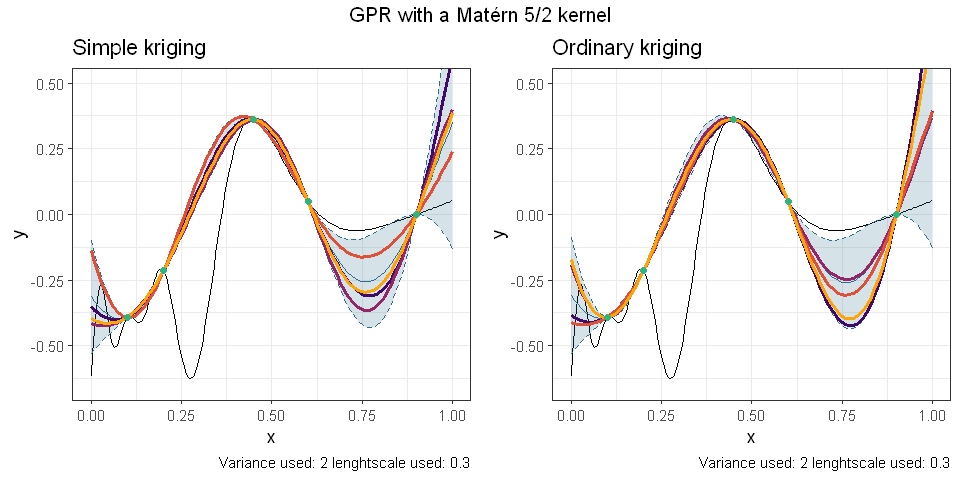

In [17]:
coef(k) <- c(range=0.3, var=2)
mod1 <- gp(y~1, cov=k, data=df_obs, estim=FALSE)
pred1 <- predict(mod1, newdata=data.frame(x=xnew), type="UK", covCompute=TRUE)
df_simu1 <- data.frame(x=rep(xnew, nsim), 
                       y=c(t(mvrnorm(nsim, mu=pred1$mean, Sigma=pred1$cov))), 
                       real=c(t(matrix(seq(nsim), nrow=nsim, ncol=length(xnew)))))

plot_UK_1 <- gp_plot(initial_plot=plot_ref,  gp_point=xnew, 
                     gp_mean=pred1$mean, gp_var=pred1$sd^2, df_sim=df_simu1) + 
  ggtitle("Ordinary kriging")+
  labs(caption=paste0("Variance used: ", 2, " lenghtscale used: ", 0.3))

annotate_figure(ggarrange(plot_SK_1+
                          ggtitle("Simple kriging"), 
                          plot_UK_1),
                top="GPR with a Matérn 5/2 kernel")


## Changing the lengthscale

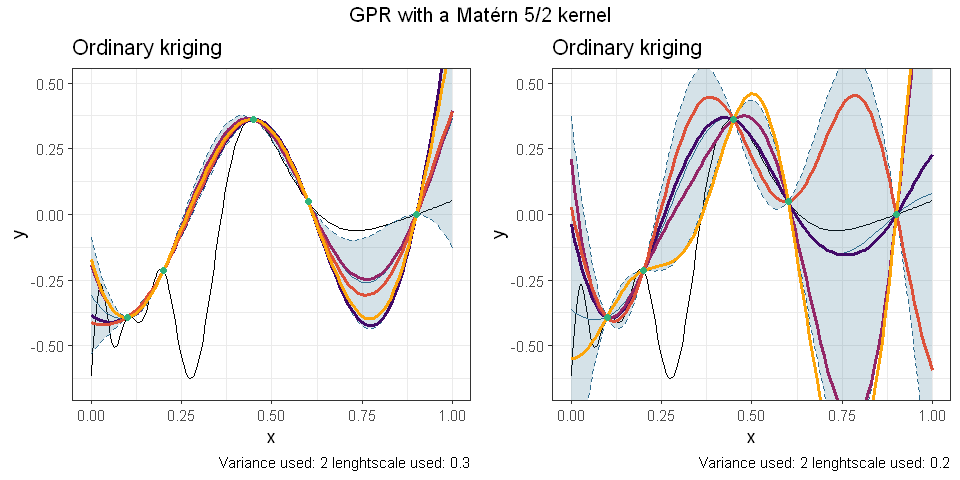

In [18]:
coef(k) <- c(range=0.2, var=2)
mod2 <- gp(y~1, cov=k, data=df_obs, estim=FALSE)
pred2 <- predict(mod2, newdata=data.frame(x=xnew), type="UK", covCompute=TRUE)
df_simu2 <- data.frame(x=rep(xnew, nsim), 
                       y=c(t(mvrnorm(nsim, mu=pred2$mean, Sigma=pred2$cov))), 
                       real=c(t(matrix(seq(nsim), nrow=nsim, ncol=length(xnew)))))
plot_UK_2 <- gp_plot(initial_plot=plot_ref,  gp_point=xnew, 
                     gp_mean=pred2$mean, gp_var=pred2$sd^2, df_sim=df_simu2) + 
ggtitle("Ordinary kriging")+
  labs(caption=paste0("Variance used: ", 2, " lenghtscale used: ", 0.2))

annotate_figure(ggarrange(plot_UK_1, 
                          plot_UK_2),
                top="GPR with a Matérn 5/2 kernel")



## Changing the variance

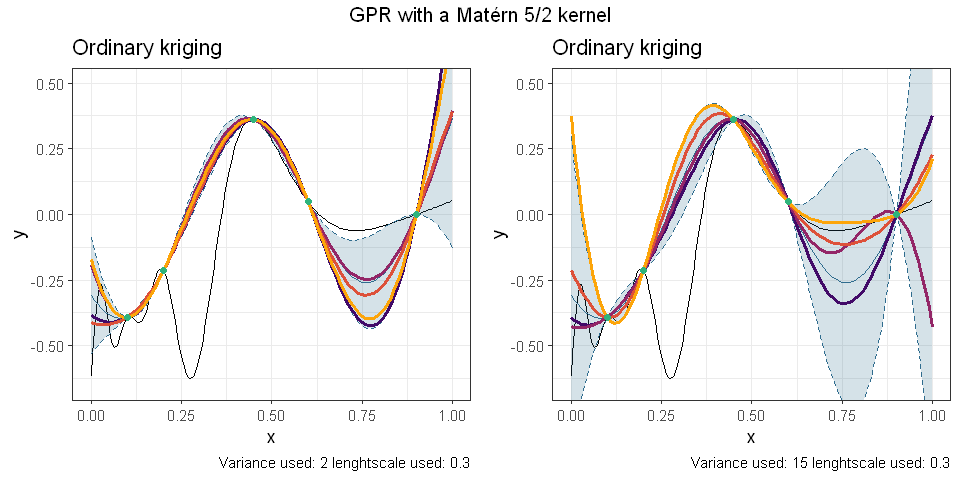

In [19]:
coef(k) <- c(range=0.3, var=15)
mod3 <- gp(y~1, cov=k, data=df_obs, estim=FALSE)
pred3 <- predict(mod3, newdata=data.frame(x=xnew), type="UK", covCompute=TRUE)
df_simu3 <- data.frame(x=rep(xnew, nsim), 
                       y=c(t(mvrnorm(nsim, mu=pred3$mean, Sigma=pred3$cov))), 
                       real=c(t(matrix(seq(nsim), nrow=nsim, ncol=length(xnew)))))
plot_UK_3 <- gp_plot(initial_plot=plot_ref,  gp_point=xnew, 
                     gp_mean=pred3$mean, gp_var=pred3$sd^2, df_sim=df_simu3) + 
ggtitle("Ordinary kriging")+
  labs(caption=paste0("Variance used: ", 15, " lenghtscale used: ", 0.3))

annotate_figure(ggarrange(plot_UK_1, 
                          plot_UK_3),
                top="GPR with a Matérn 5/2 kernel")

## Changing both

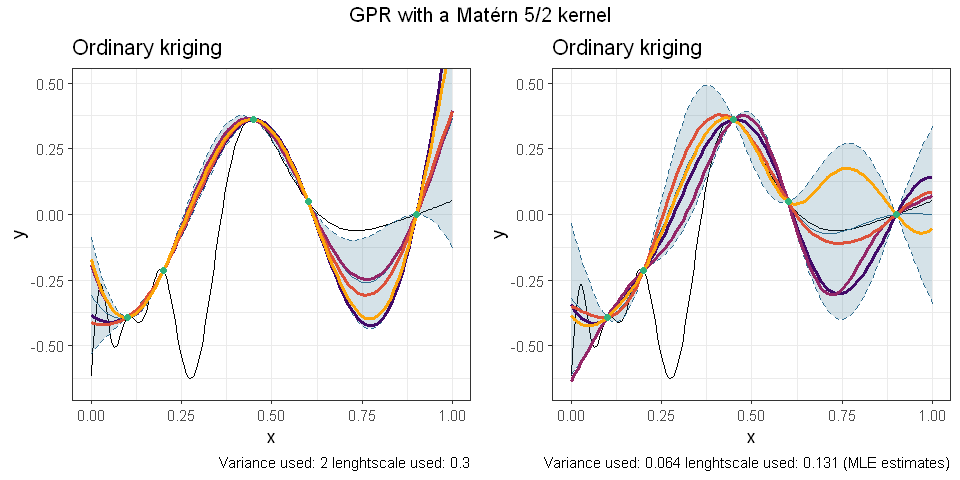

In [20]:
mod4 <- gp(y~1, cov=k, data=df_obs, noise=FALSE, optimFun = "stats::optim",
          parCovLower= c(range=0.1, var=0.01),
          parCovUpper= c(range=1, var=5))
pred4 <- predict(mod4, newdata=data.frame(x=xnew), type="UK", covCompute=TRUE)
df_simu4 <- data.frame(x=rep(xnew, nsim), 
                       y=c(t(mvrnorm(nsim, mu=pred4$mean, Sigma=pred4$cov))), 
                       real=c(t(matrix(seq(nsim), nrow=nsim, ncol=length(xnew)))))
plot_UK_4 <- gp_plot(initial_plot=plot_ref,  gp_point=xnew, 
                     gp_mean=pred4$mean, gp_var=pred4$sd^2, df_sim=df_simu4) + 
ggtitle("Ordinary kriging")+
  labs(caption=paste0("Variance used: ", round(mod4$covariance@par[["var"]], 3), 
                      " lenghtscale used: ", round(mod4$covariance@par[["range"]], 3), " (MLE estimates)"))

annotate_figure(ggarrange(plot_UK_1, 
                          plot_UK_4),
                top="GPR with a Matérn 5/2 kernel")